# Reading Gaze Data & Visualization

## In this notebook we will work on the gaze data in order to understand its structure and geometry

#### There are different data structures that are used for storing gaze tracking data. Among them Pupil labs saves its gaze calibration results into multiple csv files:
* pupil_positions.csv where the result of pupil tracking, ellipse fit, confidence values, etc. are stored
* gaze_positions.csv where the 2D/3D gaze points/vectors are stored

In [3]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import cv2
from matplotlib import cm
import matplotlib.colors as mcolors

#### Our world camera has a certain horizontal and vertical field of view
#### One way to transform gaze pixel values to angular gaze vectors is to apply a scale factor corresponding to pixels/degree.
#### This is not the most accurate way for working with eye movement data, however, for the purpose of this exercise it would allow us to visualize the 2D histogram of the gaze positions in the angular space


* We first read in a csv file that has all the gaze information per frame
* We then plot 2D historgram of certain parts of the recording to understand its geometry

In [2]:
horizontal_pixels = 2048
vertical_pixels = 1536
horizontal_FOV = 119.4
vertical_FOV = 82.0


In [6]:
session_files = sorted(glob.glob('/home/data/vedb_processed/*'))
session_files

['/home/data/vedb_processed/2020_09_28_20_53_15',
 '/home/data/vedb_processed/2020_10_19_00_23_14',
 '/home/data/vedb_processed/2021_01_11_16_33_39',
 '/home/data/vedb_processed/2021_02_01_23_53_59',
 '/home/data/vedb_processed/2021_02_08_16_24_36',
 '/home/data/vedb_processed/2021_02_22_10_35_01',
 '/home/data/vedb_processed/2021_02_22_20_40_52',
 '/home/data/vedb_processed/2021_02_25_16_28_15',
 '/home/data/vedb_processed/2021_03_04_17_01_45',
 '/home/data/vedb_processed/2021_03_04_22_37_35',
 '/home/data/vedb_processed/2021_03_14_14_13_55',
 '/home/data/vedb_processed/2021_04_11_09_26_11',
 '/home/data/vedb_processed/2021_05_15_10_30_33',
 '/home/data/vedb_processed/frame_stack.npy',
 '/home/data/vedb_processed/gaze_left.npz',
 '/home/data/vedb_processed/gaze_right.npz']

In [9]:
ls /home/data/vedb_processed/2021_04_11_09_26_11

gaze_2D_PL_left_eye.csv*   PL_binocular_2D-PL_calibration_ref_pos.npz*
gaze_2D_PL_right_eye.csv*  PL_binocular_2D-PL_pupil_pos_left.npz*
gaze_left_eye.npz*         PL_binocular_2D-PL_pupil_pos_right.npz*
gaze_left.npz*             PL_binocular_2D-PL_validation_ref_pos_dict.npz*
gaze_right_eye.npz*        PL_binocular_2D-PL_validation_ref_pos.npz*
gaze_right.npz*


In [10]:

gaze_file = "/home/data/vedb_processed/2021_04_11_09_26_11/gaze_2D_PL_left_eye.csv"
gazeDataFrame = pd.read_csv(gaze_file)


ratio_x = horizontal_FOV/horizontal_pixels
ratio_y = vertical_FOV/vertical_pixels

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def pixels_to_angle_x(array):
    return (array - horizontal_pixels/2) * ratio_x

def pixels_to_angle_y(array):
    return (array - vertical_pixels/2) * ratio_y


gaze_norm_x = gazeDataFrame.iloc[:].norm_pos_x.values
gaze_norm_y = gazeDataFrame.iloc[:].norm_pos_y.values

gaze_pixel_x = gaze_norm_x * horizontal_pixels
gaze_pixel_y = gaze_norm_y * vertical_pixels

print('gazeX shape = ', gaze_pixel_x.shape)
print('gazeY shape = ',gaze_pixel_y.shape)

gaze_az = pixels_to_angle_x(gaze_pixel_x)
gaze_el = pixels_to_angle_y(gaze_pixel_y)

# This is important because the gaze values should be inverted in y direction
# Due to coordinate transform from opencv
gaze_el = -gaze_el


gazeX shape =  (88144,)
gazeY shape =  (88144,)


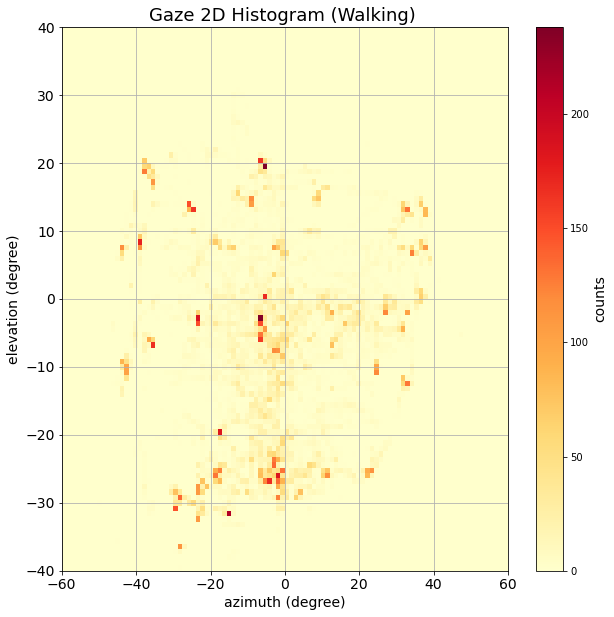

In [11]:
# Feel free to change the start and end range below to only show the gaze pattern over a certain part of the recording
start_index = 30*120
end_index = 300*120
frame_index = range(start_index, end_index)

x_min = -60 
x_max = 60
y_min = -40 
y_max = 40

fig = plt.figure(figsize = (10,10))
plt.hist2d(gaze_az[frame_index], gaze_el[frame_index], range = [[x_min, x_max], [y_min, y_max]],
            bins=(100, 100), cmap='YlOrRd')
cb = plt.colorbar()
cb.set_label('counts', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plt.title('Gaze 2D Histogram (Walking) ', fontsize = 18)
plt.xlabel('azimuth (degree)', fontsize = 14)
plt.ylabel('elevation (degree)', fontsize = 14)

plt.grid(True)
# plt.axis('equal')
plt.savefig('2D_gaze_histogram.png', dpi = 200 )
plt.show()


#### 2D histograms especially for gaze data could be misleading, because it might be that the participant was looking at certain portiion of the field of view much more than the entire FOV therefore we'd end up with a dark peak and the rest of the colors would be more or less the same.

#### One way to correct for this effect is to apply some sort of gamma correction to the color intensities so that the difference between less frequent gaze positions and the dominant ones become more apparent. The code below is almost exactly the same but with adding a gamma curve to the 2D heatmap. Check out the difference with changing different gamma values.

(-60.0, 60.0, -40.0, 40.0)

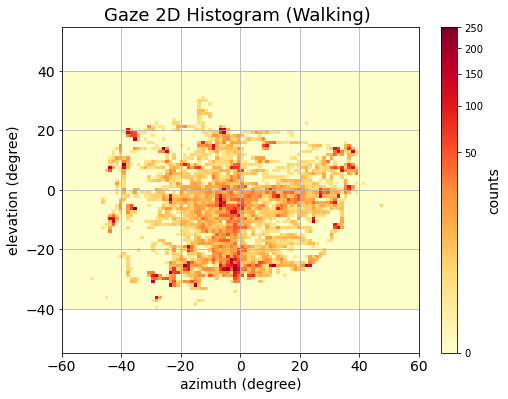

In [14]:
gamma = 0.3

fig = plt.figure(figsize = (8,6))
plt.hist2d(gaze_az[frame_index], gaze_el[frame_index], range = [[x_min, x_max], [y_min, y_max]],
            bins=(100, 75), cmap='YlOrRd', norm=mcolors.PowerNorm(gamma))
cb = plt.colorbar()
cb.set_label('counts', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plt.title('Gaze 2D Histogram (Walking) ', fontsize = 18)
plt.xlabel('azimuth (degree)', fontsize = 14)
plt.ylabel('elevation (degree)', fontsize = 14)

plt.grid(True)
#plt.axis('equal')
#plt.savefig('2D_gaze_histogram_gamma.png', dpi = 200 )
#plt.show()
